## Dogs Vs Cats Image Classifier
### Using Convolutional Neural Network and Data Augmentation Technique

- https://www.kaggle.com/c/dogs-vs-cats/overview
- Write an algorithm to classify whether images contain either a dog or a cat.

## Convolutional Neural Network
#### Convolution
The ultimate purpose of convolution layer is to receive a feature map. Usually, we start with low number of filters for low-level feature detection. The deeper we go into the CNN, the more filters (usually they are also smaller) we use to detect high-level features.
#### Activation
After this we apply ReLU activation function that returns 0 for every negative value in the input image while it returns the same value for every positive value.
#### Pooling
The goal of this layer is to provide spatial variance, which simply means that the system will be capable of recognizing an object as an object even when its appearance varies in some way. Pooling layer will perform a downsampling operation along the spatial dimensions (width, height).

#### Fully-Connected
In a fully connected layer, we flatten the output of the last convolution layer and connect every node of the current layer with the other node of the next layer. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks and work in a similar way. The last layer of our CNN will compute the class probability scores.

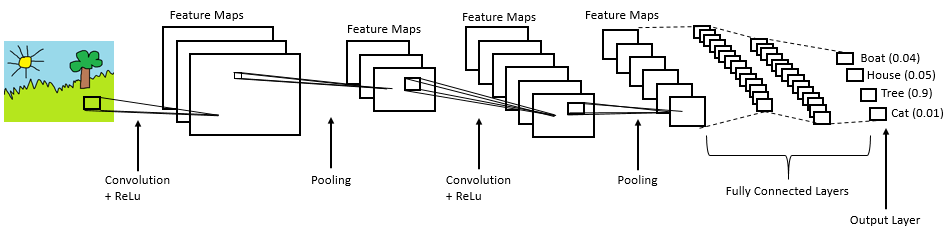

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D

from livelossplot.keras import PlotLossesCallback

In [2]:
# Load Data
path = "/content/drive/MyDrive/Google Colab Notebooks/CNN/DogsVsCats/"
training_data_dir = path + "data/training/" # 10,000 * 2 images
validation_data_dir = path + "data/validation/" # 2,500 * 2 images
test_data_dir = path + "test/" # 12,500 images

### Data Augmentation
It is used to create new images from existing images by adding rotaion, flip, zoom, shift and so on.

In [3]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [4]:
# rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
# width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
# rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, 
# but such values would be too high for our models to process, so we target values between 0 and 1 instead by scaling with a 1./255 factor.
# shear_range is for randomly applying shearing transformations
# zoom_range is for randomly zooming inside pictures
# horizontal_flip is for randomly flipping half of the images horizontally
# fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

datagen=ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [5]:
img = load_img('/content/drive/MyDrive/Google Colab Notebooks/CNN/DogsVsCats/test/4.jpg')
x = img_to_array(img)  # this will create a Numpy array with shape (pixel, pixel, 3) 
x.shape

(288, 374, 3)

In [6]:
# Change the above Numpy array to 4D arrray (1, pixel, pixel, 3) where 3 is for RGB layers and 150 is for pixels (150*150)
x = x.reshape((1,) + x.shape)  
x.shape

(1, 288, 374, 3)

In [7]:
# The .flow() command below generates batches of randomly transformed images and saves the results to the `temp` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/Google Colab Notebooks/CNN/DogsVsCats/temp/', 
                          save_prefix='dog', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [8]:
# Applying the above illustrated concept on actual data
training_data_generator = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [24]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


### Create CNN Model

In [25]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

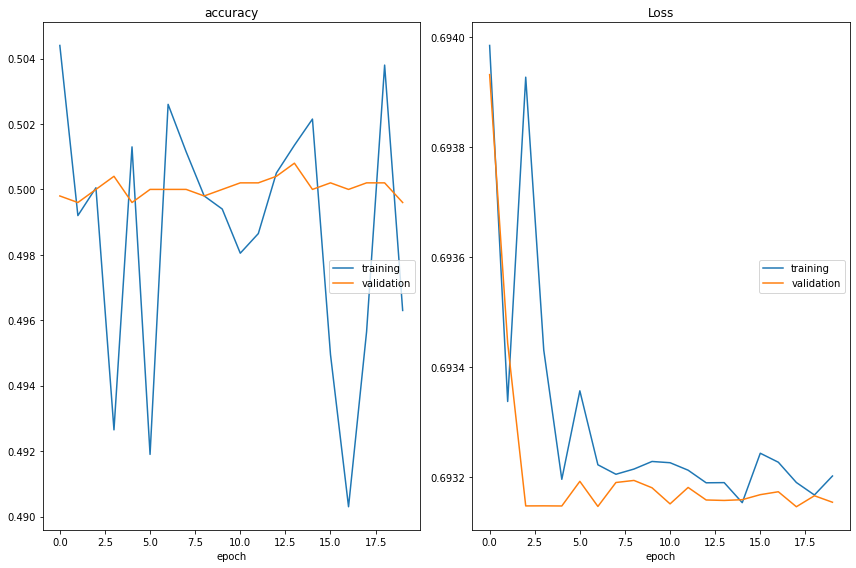

accuracy
	training         	 (min:    0.490, max:    0.504, cur:    0.496)
	validation       	 (min:    0.500, max:    0.501, cur:    0.500)
Loss
	training         	 (min:    0.693, max:    0.694, cur:    0.693)
	validation       	 (min:    0.693, max:    0.694, cur:    0.693)


In [26]:
# Training
model.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=PlotLossesCallback(), 
    verbose=1)